# MODELING FINAL VERSION FEB22

### LOADING LIBRARIES

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

### DEFINING NECESSARY FUNCTIONS

In [2]:
def max_pooling_batch(matrices, new_shape):
    original_batch, original_height, original_width = matrices.shape  
    target_height, target_width = new_shape
    pool_size = original_width // target_width
    reshaped = matrices.reshape(original_batch, original_height, target_width, pool_size)
    pooled = np.max(reshaped, axis=3)
    return pooled

def count_and_percentage(array):
    flattened = array.flatten()
    unique, counts = np.unique(flattened, return_counts=True)
    total_elements = flattened.size
    count_dict = dict(zip(unique, counts))
    percentage_dict = {key: (value / total_elements) * 100 for key, value in count_dict.items()}
    return count_dict, percentage_dict

def resize_tensor_bilinear(tensor, target_size, mode='bilinear'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode, align_corners=False)
    return resized.squeeze(0)

def resize_tensor_nearest(tensor, target_size, mode='nearest'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode)
    return resized.squeeze(0)


def normalize_tensor(tensor):
    min_val = tensor.min(dim=-1, keepdim=True).values.min(dim=-2, keepdim=True).values
    max_val = tensor.max(dim=-1, keepdim=True).values.max(dim=-2, keepdim=True).values
    return ((tensor - min_val) / ((max_val - min_val) + 1e-8))

### LOADING DATA

##### LOADING ELEVATION, VEGETATION, SOIL VARIABLE AND SOIL COMPOSITION

In [3]:
#ELEVATION DATA
elevation_data = np.load('elevation_matrix.npy') 

#VEGETATION DATA
vegetation_data = np.load('NLCD2021_OR.npy') 

#SOIL VARIABLE DATA
directory = "ERA5_matrices"  
npy_files = sorted([f for f in os.listdir(directory) if f.endswith('.npy')])
matrices = [np.load(os.path.join(directory, file)) for file in npy_files]
data = np.stack(matrices, axis=0)  # Shape: (num_files, height, width)
soil_variable_data = np.transpose(data, (1, 0, 2, 3)) 

#SOIL COMPOSITION DATA
data_folder = "SOLUS"
npy_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]
num_files = len(npy_files)
transformed_data_list = []
pca = PCA(n_components=1)
for file in npy_files:
    file_path = os.path.join(data_folder, file)
    soil_data = np.load(file_path)
    try:
        reshaped_data = soil_data.reshape(7, -1).T
    except:
        print(file)
        continue
    principal_component = pca.fit_transform(reshaped_data)  
    reduced_data = principal_component.reshape(1306, 464)
    transformed_data_list.append(reduced_data)
soil_composition_data = np.stack(transformed_data_list, axis=0) 

In [4]:
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")


ELEVATION DATA : (10812, 10812)
VEGETATION DATA : (15, 4353, 1547)
SOIL VARIABLE DATA : (1096, 28, 5, 5)
SOIL COMPOSITION DATA : (18, 1306, 464)


##### LOADING OUTPUT LABELS

In [5]:
label = np.load('landslide_labels_stored_sequentially_compressed.npz') 
output_labels = label['matrix']
labels_resized = max_pooling_batch(output_labels, (120, 120))  # Output shape: (1096, 120, 120)
counts, percentages = count_and_percentage(labels_resized)
print("Counts:", counts)  
print("Percentages:", percentages)

Counts: {0.0: 15118676, 1.0: 303439, 2.0: 360285}
Percentages: {0.0: 95.79453061638281, 1.0: 1.9226416768045418, 2.0: 2.282827706812652}


In [6]:
print(f"OUTPUT LABELS : {labels_resized.shape}")

OUTPUT LABELS : (1096, 120, 120)


### CONVERTING NUMPY ARRAYS TO TENSORS

In [7]:
elevation_data = torch.tensor(elevation_data, dtype=torch.float).unsqueeze(0)  # (1, 10812, 10812)
vegetation_data = torch.tensor(vegetation_data, dtype=torch.float)             # (15, 4353, 1547)
soil_composition_data = torch.tensor(soil_composition_data, dtype=torch.float) # (18, 1306, 464)
soil_variable_data = torch.tensor(soil_variable_data, dtype=torch.float)       # (1096, 28, 5, 5)
output_labels = torch.tensor(labels_resized, dtype=torch.long)                 # (1096, 120, 120)

In [8]:
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")
print(f"OUTPUT LABELS : {output_labels.shape}")

ELEVATION DATA : torch.Size([1, 10812, 10812])
VEGETATION DATA : torch.Size([15, 4353, 1547])
SOIL VARIABLE DATA : torch.Size([1096, 28, 5, 5])
SOIL COMPOSITION DATA : torch.Size([18, 1306, 464])
OUTPUT LABELS : torch.Size([1096, 120, 120])


### PREPROCESSING THE TENSORS

##### TARGET SPATIAL RESOLUTION (HEIGHT,WIDTH)

In [9]:
target_size = (120, 120)

In [10]:
elevation_normalized = (elevation_data - elevation_data.min()) / (elevation_data.max() - elevation_data.min())
soil_composition_normalized = torch.stack([normalize_tensor(t1) for t1 in soil_composition_data])
soil_variable_normalized = torch.stack([normalize_tensor(t2) for t2 in soil_variable_data])

##### NORMALIZE THE CONTINOUS FEATURES (ELEVATION AND SOIL COMPOSITION)

In [11]:
print(torch.isnan(elevation_normalized).any())
print(torch.isnan(vegetation_data).any())
print(torch.isnan(soil_composition_normalized).any())
print(torch.isnan(soil_variable_data).any())
print(torch.isnan(output_labels).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


### CUSTOM DATASET CLASS

In [12]:
class DayDataset(Dataset):
    def __init__(self, day_indices, vegetation, elevation, soil_comp, soil_var, labels):
        """
        Args:
          day_indices: list of day indices (e.g., [0, 1, 2, ...])
          vegetation: static vegetation data, already resized, shape (15, target_H, target_W)
          elevation: static elevation data, already resized, shape (1, target_H, target_W)
          soil_comp: static soil composition data, already resized, shape (18, target_H, target_W)
          soil_var: daily soil variable data, shape (1096, 28, 5, 5)
          labels: daily output labels, shape (1096, target_H, target_W)
          target_size: the target spatial size (target_H, target_W) for all inputs
        """
        self.day_indices = day_indices
        self.vegetation = vegetation
        self.elevation = elevation
        self.soil_comp = soil_comp
        self.soil_var = soil_var
        self.labels = labels

    def __len__(self):
        return len(self.day_indices)

    def __getitem__(self, idx):
        day = self.day_indices[idx]
        soil_var_day = self.soil_var[day] 
        #input_tensor = torch.cat([self.vegetation, self.elevation, self.soil_comp, soil_variable_normalized], dim=0)
        label = self.labels[day]
        
        return self.vegetation, self.elevation, self.soil_comp, soil_var_day, label

##### DEFINING TRAIN DAYS, VALIDATION DAYS AND TEST DAYS 

In [13]:
# all_days = list(range(1096))
# train_days = list(range(0, 730))
# test_days = list(range(730, 1096))
# val_days = train_days[-100:] 
# train_days = train_days[:-100]
all_days = list(range(1096))
train_days = list(range(0, 730))
test_days = list(range(730, 1096))
val_days = random.sample(train_days, 100) # Randomly select 100 days from train_days for validation
train_days = [day for day in train_days if day not in val_days] # Remove the selected validation days from train_days

##### CREATING DATASETS AND DATALOADERS

In [14]:
# train_dataset = DayDataset(train_days, vegetation_resized, elevation_normalized,
#                            soil_composition_normalized, soil_variable_data, output_labels, target_size)
# val_dataset = DayDataset(val_days, vegetation_resized, elevation_normalized,
#                          soil_composition_normalized, soil_variable_data, output_labels, target_size)
# test_dataset = DayDataset(test_days, vegetation_resized, elevation_normalized,
#                           soil_composition_normalized, soil_variable_data, output_labels, target_size)


train_dataset = DayDataset(train_days, vegetation_data, elevation_normalized,
                           soil_composition_normalized, soil_variable_normalized, output_labels)
val_dataset = DayDataset(val_days, vegetation_data, elevation_normalized,
                           soil_composition_normalized, soil_variable_normalized, output_labels)
test_dataset = DayDataset(test_days, vegetation_data, elevation_normalized,
                           soil_composition_normalized, soil_variable_normalized, output_labels)


# train_dataset = DayDataset(train_days, vegetation_resized, elevation_resized,
#                            soil_composition_resized, soil_variable_data, output_labels, target_size)
# val_dataset = DayDataset(val_days, vegetation_resized, elevation_resized,
#                          soil_composition_resized, soil_variable_data, output_labels, target_size)
# test_dataset = DayDataset(test_days, vegetation_resized, elevation_resized,
#                           soil_composition_resized, soil_variable_data, output_labels, target_size)



batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### DEFINING FULLY CONVOLUTIONAL NETWORK (FCN)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottom (bottleneck)
        self.bottom = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),  # Concatenated channels from enc3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),  # Concatenated channels from enc2
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),    # Concatenated channels from enc1
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)   # (64, H, W)
        p1 = self.pool1(x1) # (64, H/2, W/2)

        x2 = self.enc2(p1)  # (128, H/2, W/2)
        p2 = self.pool2(x2) # (128, H/4, W/4)

        x3 = self.enc3(p2)  # (256, H/4, W/4)
        p3 = self.pool3(x3) # (256, H/8, W/8)

        # Bottleneck
        x_bottom = self.bottom(p3) # (512, H/8, W/8)

        # Decoder
        d3 = self.upconv3(x_bottom)        # (256, H/4, W/4)
        d3 = torch.cat([d3, x3], dim=1)      # (256 + 256, H/4, W/4)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)              # (128, H/2, W/2)
        d2 = torch.cat([d2, x2], dim=1)      # (128 + 128, H/2, W/2)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)              # (64, H, W)
        d1 = torch.cat([d1, x1], dim=1)      # (64 + 64, H, W)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)          # (num_classes, H, W)
        return out

# Example usage:
in_channels = 15 + 1 + 18 + 28  # As defined in your FCN
num_classes = 3
model = UNet(in_channels, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/shelly/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


UNet(
  (enc1): Sequential(
    (0): Conv2d(62, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottom): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=

### TRAINING LOOP

##### DEFINING EARLY STOPPING

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

##### DEFINING THE LOSS FUNCTION AND OPTIMIZER

##### TRAINING LOOP

In [17]:
from MutliModalFCNew import *

In [18]:
num_classes = 3
model_veg = VegetationNet()
model_elevation = ElevationNet()
model_ERA = SoilVariableNet()
model_solus = SoilCompositionNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_veg.to(device)
model_elevation.to(device)
model_ERA.to(device)
model_solus.to(device)

SoilCompositionNet(
  (conv): Sequential(
    (0): Conv2d(18, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(120, 120))
)

In [19]:
freq = torch.tensor([0.9579453061638281, 0.019226416768045418, 0.02282827706812652])
weights = 1.0 / freq
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights)  
optimizer = optim.AdamW(list(model.parameters())+list(model_veg.parameters())+list(model_elevation.parameters())+
                        list(model_ERA.parameters())+list(model_solus.parameters()), lr=0.01, weight_decay=0.0001)
early_stopping = EarlyStopping(patience=15, delta=0.01)

In [20]:
import time

start = time.time()
num_epochs = 200
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10 # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss as a large number
patience_counter = 0.0 # Counter for epochs with no improvement
best_model_veg = ""
best_model_elevation = ""
best_model_ERA = ""
best_model_solus = ""
best_model = ""
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    counter = 0
    for inputs in train_loader:
        print(counter)
        counter += 1
        labels = inputs[-1].to(device)
        
        optimizer.zero_grad()
        
        veg = model_veg(inputs[0].to(device))
        elevation = model_elevation(inputs[1].to(device))
        era = model_ERA(inputs[3].to(device))
        solus = model_solus(inputs[2].to(device))
        
        outputs = model(torch.cat((veg, elevation, era, solus), dim=1))      # shape: (B, 3, 120, 120)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs[0].size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            labels = inputs[-1].to(device)
            
            veg = model_veg(inputs[0].to(device))
            elevation = model_elevation(inputs[1].to(device))
            era = model_ERA(inputs[3].to(device))
            solus = model_solus(inputs[2].to(device))
            
            outputs = model(torch.cat((veg, elevation, era, solus), dim=1))
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs[0].size(0)
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")


    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # Reset counter if we have improvement
        best_model_veg = model_veg
        best_model_elevation = model_elevation
        best_model_ERA = model_ERA
        best_model_solus = model_solus
        best_model = model
        
        
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

epochs_run = epoch + 1

end = time.time()
duration = (end-start)/60
print(f"The training loop ran for {round(duration,2)} minutes for {epochs_run} epochs.")
model_veg = best_model_veg
model_elevation = best_model_elevation
model_ERA = best_model_ERA
bmodel_solus = best_model_solus
model = best_model

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 1/200  Train Loss: 1.0003  Val Loss: 1.2672
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 2/200  Train Loss: 0.8145  Val Loss: 0.8045
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 3/200  Train Loss: 0.7445  Val Loss: 0.7327
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 4/200  Train Loss: 0.7018  Val Loss: 0.7291
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 5/200  Train Loss: 0.6823  Val Loss: 0.7156
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 6/200  Train Loss: 0.6628  Val Loss: 0.6652
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Epoch 7/200  Train Loss: 0.6452  Val Loss: 1.0397
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
1

##### TRAINING LOSS AND VALIDATION LOSS PLOT

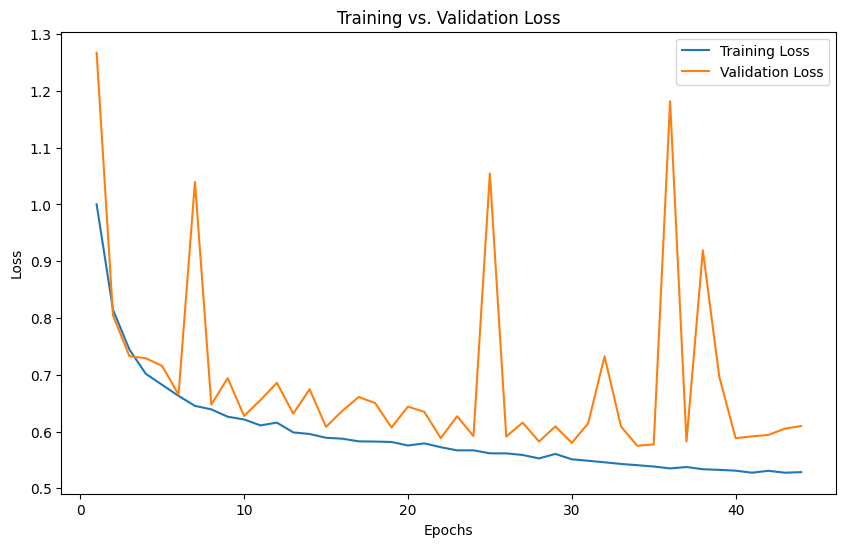

In [21]:
import matplotlib.pyplot as plt

epochs = list(range(1, epochs_run + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

### MODEL TESTING

In [22]:
def compute_iou(pred, target, num_classes=3):
    """
    Compute the Intersection over Union (IoU) for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: IoU for each class.
    """
    ious = []
    # Flatten the tensors for easier computation.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious.append(float('nan'))  # Alternatively, you might want to append 0.0
        else:
            ious.append((intersection / union).item())
    return ious

def compute_dice(pred, target, num_classes=3):
    """
    Compute the Dice coefficient for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: Dice coefficient for each class.
    """
    dices = []
    # Flatten the tensors.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()
        if total == 0:
            dices.append(float('nan'))
        else:
            dices.append((2 * intersection / total).item())
    return dices

def compute_confusion_matrix(pred, target, num_classes=3):
    """
    Compute a confusion matrix where the rows correspond to true classes
    and the columns correspond to predicted classes.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      torch.Tensor: A (num_classes, num_classes) confusion matrix.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    # Use torch.bincount to count occurrences of each (true, pred) pair.
    cm = torch.bincount(num_classes * target + pred, minlength=num_classes**2)
    cm = cm.reshape(num_classes, num_classes)
    return cm

def compute_precision_recall_f1(conf_matrix):
    """
    Compute per-class precision, recall, and F1 score from a confusion matrix.
    Args:
      conf_matrix (torch.Tensor): A (num_classes, num_classes) confusion matrix.
    Returns:
      tuple: Three lists containing precision, recall, and F1 score for each class.
    """
    num_classes = conf_matrix.shape[0]
    precisions = []
    recalls = []
    f1s = []
    for i in range(num_classes):
        TP = conf_matrix[i, i].item()
        FP = conf_matrix[:, i].sum().item() - TP
        FN = conf_matrix[i, :].sum().item() - TP
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
        recall    = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else float('nan')
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

In [23]:
model.eval()
model_veg.eval()
model_elevation.eval()
model_ERA.eval()
model_solus.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs in test_loader:
        labels = inputs[-1].to(device)
        
        optimizer.zero_grad()
        
        veg = model_veg(inputs[0].to(device))
        elevation = model_elevation(inputs[1].to(device))
        era = model_ERA(inputs[3].to(device))
        solus = model_solus(inputs[2].to(device))
        
        outputs = model(torch.cat((veg, elevation, era, solus), dim=1))      # shape: (B, 3, 120, 120)
        
        test_loss += loss.item() * inputs[0].size(0)
        
        # Convert raw logits to predicted class labels (shape: (batch_size, H, W))
        preds = torch.argmax(outputs, dim=1)
        
        # Collect predictions and ground truth labels for metric computations
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Calculate average test loss over the dataset
test_loss = test_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Concatenate all the collected predictions and labels along the batch dimension
all_preds = torch.cat(all_preds, dim=0)
print(all_preds.shape)
all_labels = torch.cat(all_labels, dim=0)
print(all_labels.shape)


# Compute metrics using the functions defined earlier
ious = compute_iou(all_preds, all_labels, num_classes=3)
dices = compute_dice(all_preds, all_labels, num_classes=3)
conf_matrix = compute_confusion_matrix(all_preds, all_labels, num_classes=3)
precisions, recalls, f1s = compute_precision_recall_f1(conf_matrix)

print("IoU per class:", ious)
print("Dice per class:", dices)
print("Confusion Matrix:\n", conf_matrix)
print("Precision per class:", precisions)
print("Recall per class:", recalls)
print("F1 per class:", f1s)


Test Loss: 0.5777
torch.Size([366, 120, 120])
torch.Size([366, 120, 120])
IoU per class: [0.710218608379364, 0.06956788897514343, 0.11288613080978394]
Dice per class: [0.8305588364601135, 0.13008597493171692, 0.2028709501028061]
Confusion Matrix:
 tensor([[3610277,  762044,  692554],
        [   9487,   60182,   20224],
        [   8970,   13146,   93516]])
Precision per class: [0.9949136530812124, 0.07204215606939184, 0.1159825076212895]
Recall per class: [0.7128067326439448, 0.669484831966894, 0.8087380655873807]
F1 per class: [0.8305588622630716, 0.13008597536921854, 0.20287094625815955]


In [24]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score

# Example tensors (replace these with your actual data)
# predictions = torch.randint(0, 3, (366, 120, 120))
# true_labels = torch.randint(0, 3, (366, 120, 120))

# Flatten the tensors so each pixel is one element
pred_flat = all_preds.view(-1)
true_flat = all_labels.view(-1)

# 1. Pixel Accuracy
pixel_accuracy = (pred_flat == true_flat).float().mean().item()
print("Pixel Accuracy:", pixel_accuracy)

# 2. Confusion Matrix
cm = confusion_matrix(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)

# 3. Precision, Recall, and F1 Score (per class)
precision = precision_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
recall = recall_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
f1 = f1_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

# 4. Intersection over Union (IoU) for each class
def compute_iou(pred, true, num_classes=3):
    ious = []
    for cls in range(num_classes):
        # Create masks for the current class
        pred_inds = (pred == cls)
        true_inds = (true == cls)
        # Calculate intersection and union
        intersection = (pred_inds & true_inds).sum().float()
        union = (pred_inds | true_inds).sum().float()
        if union.item() == 0:
            ious.append(float('nan'))  # Avoid division by zero if class is not present in the true labels
        else:
            ious.append((intersection / union).item())
    return ious

ious = compute_iou(pred_flat, true_flat)
print("IoU per class:", ious)

# 5. Dice Coefficient for each class
def compute_dice(pred, true, num_classes=3, eps=1e-6):
    dices = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        true_inds = (true == cls)
        intersection = (pred_inds & true_inds).sum().float()
        dice = (2 * intersection) / (pred_inds.sum() + true_inds.sum() + eps)
        dices.append(dice.item())
    return dices

dices = compute_dice(pred_flat, true_flat)
print("Dice Coefficient per class:", dices)

# 6. Cohen's Kappa
kappa = cohen_kappa_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())
print("Cohen's Kappa:", kappa)

# 7. Balanced Accuracy
balanced_acc = balanced_accuracy_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())
print("Balanced Accuracy:", balanced_acc)


Pixel Accuracy: 0.7141725420951843
Confusion Matrix:
 [[3610277  762044  692554]
 [   9487   60182   20224]
 [   8970   13146   93516]]
Precision per class: [0.99491365 0.07204216 0.11598251]
Recall per class: [0.71280673 0.66948483 0.80873807]
F1 Score per class: [0.83055886 0.13008598 0.20287095]
IoU per class: [0.710218608379364, 0.06956788897514343, 0.11288613080978394]
Dice Coefficient per class: [0.8305588364601135, 0.13008597493171692, 0.2028709501028061]
Cohen's Kappa: 0.13979236610811951
Balanced Accuracy: 0.7303432100660733


In [25]:
print(all_preds.shape)
print(all_labels.shape)

torch.Size([366, 120, 120])
torch.Size([366, 120, 120])
